In [6]:
import numpy as np
import qiskit as qis

from numpy.random import default_rng

from qiskit.exceptions import QiskitError
from qiskit.quantum_info.operators.random import * 
from qiskit_aer.backends import AerSimulator
from qiskit.quantum_info import *
from qiskit.primitives import Sampler

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector

from qiskit.quantum_info import Pauli
from qiskit_aer.noise import NoiseModel, pauli_error
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error, amplitude_damping_error)
#from qiskit.extensions import Initialize

from matplotlib.pyplot import figure



%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [11]:
from qiskit import QuantumCircuit, QuantumRegister

class LogicalToQuantumConverter:
    def __init__(self, expression):
        self.expression = expression
        self.variables = self.extract_variables(expression)
        self.num_ancilla = self.count_connectives(expression)
        self.qubits_map, self.ancilla_start = self._map_qubits()
        self.circuit = self._initialize_circuit()
        self.amp_circ = QuantumCircuit(len(self.qubits_map)) #self._initialize_circuit()
    
    def extract_variables(self, expr):
        variables = set()
        if isinstance(expr, list):
            for sub_expr in expr[1:]:
                variables.update(self.extract_variables(sub_expr))
        elif isinstance(expr, str):
            variables.add(expr)
        return variables
    
    def count_connectives(self, expr):
        count = 0
        if isinstance(expr, list):
            count += 1
            for sub_expr in expr[1:]:
                count += self.count_connectives(sub_expr)
        return count
    
    def _map_qubits(self):
        var_list = sorted(list(self.variables))
        qubits_map = {var: idx for idx, var in enumerate(var_list)}
        ancilla_start = len(qubits_map)
        ancilla_map = {f"anc{i+1}": ancilla_start + i for i in range(self.num_ancilla)}
        qubits_map.update(ancilla_map)
        return qubits_map, ancilla_start
    
    def _initialize_circuit(self):
        circuit = QuantumCircuit()
        for name in sorted(self.variables):
            qreg = QuantumRegister(1, name=name)
            circuit.add_register(qreg)
        anc_reg = QuantumRegister(self.num_ancilla, name="anc")
        circuit.add_register(anc_reg)
        for q in range(len(self.variables)):
            circuit.h(q)
        return circuit
    
    def resolve_expression(self, expr, ancilla_counter):
        if isinstance(expr, str):
            return self.qubits_map[expr]
        
        if isinstance(expr, list) and len(expr) > 1:
            gate = expr[0]
            args = expr[1:]
            resolved_args = [self.resolve_expression(arg, ancilla_counter) for arg in args]
            target = self.ancilla_start + ancilla_counter[0]
            ancilla_counter[0] += 1
            
            if gate == "not" and len(resolved_args) == 1:
                self.circuit.x(resolved_args[0])
                self.circuit.cx(resolved_args[0], target)
                
            elif gate == "and" and len(resolved_args) == 2:
                self.circuit.ccx(*resolved_args, target)
                
            elif gate == "or" and len(resolved_args) == 2:
                q1, q2 = resolved_args
                self.circuit.cx(q1, target)
                self.circuit.cx(q2, target)
                self.circuit.ccx(q1, q2, target)
                
            elif gate == "xor" and len(resolved_args) == 2:
                q1, q2 = resolved_args
                self.circuit.cx(q1, target)
                self.circuit.cx(q2, target)
                                
            elif gate == "implication" and len(resolved_args) == 2:
                q1, q2 = resolved_args
                self.circuit.x(q1)
                self.circuit.cx(q1, target)
                self.circuit.cx(q2, target)
                self.circuit.ccx(q1, q2, target)
                
            elif gate == "bijection" and len(resolved_args) == 2:
                q1, q2 = resolved_args
                self.circuit.cx(q1, target)
                self.circuit.cx(q2, target)
                self.circuit.x(target)
            else:
                raise ValueError(f"Unknown or improperly formatted gate: {gate}")
            
            return target
    
    def convert(self):
        ancilla_counter = [0]
        self.resolve_expression(self.expression, ancilla_counter)
        return self.circuit, self.qubits_map, self.variables
    
    def oracle(self):
        o = QuantumCircuit(len(self.qubits_map))
        o.z(len(self.qubits_map) - 1)
        return o
        
    def diffusion(self):
        d = QuantumCircuit(len(self.qubits_map))
        d1 = d.compose(self.circuit.inverse())
        
        for qubit in range(len(self.variables)):
            d1.x(qubit)
            
        d1.h(len(self.qubits_map) - 1)
        d1.mcx(list(range(0, len(self.variables))), len(self.qubits_map) - 1)
        d1.h(len(self.qubits_map) - 1)
        
        for qubit in range(len(self.variables)):
            d1.x(qubit)
            
        d2 = d1.compose(self.circuit)
        
        return d2
    
    def amplify(self):
        
        o = self.oracle()
        d = self.diffusion()
        
        self.amp_circ = self.amp_circ.compose(self.circuit)
        
        for _ in range(math.floor(sqrt(len(self.variables)))):
            self.amp_circ = self.amp_circ.compose(o).compose(d)
            
        return self.amp_circ
        

# Example Usage
ex1 = ["or", ["or", "A", "B"], ["not", "C"]]
ex2 = ["implication", ["xor", ["and", "A", "B"], ["and", "C", "D"]], ["and", "E", "F"]]
ex3 = ["implication",   ["and", ["and", "A", "B"], ["and", "A", "C"]], "D"]
converter = LogicalToQuantumConverter(ex3)

circuit, qubits_map, variable_bits = converter.convert()

amplified_circuit = converter.amplify()


In [12]:
math.floor(sqrt(len(variable_bits)))
variable_bits

{'A', 'B', 'C', 'D'}

Our variable qubits and ancillas are: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'anc1': 4, 'anc2': 5, 'anc3': 6, 'anc4': 7}


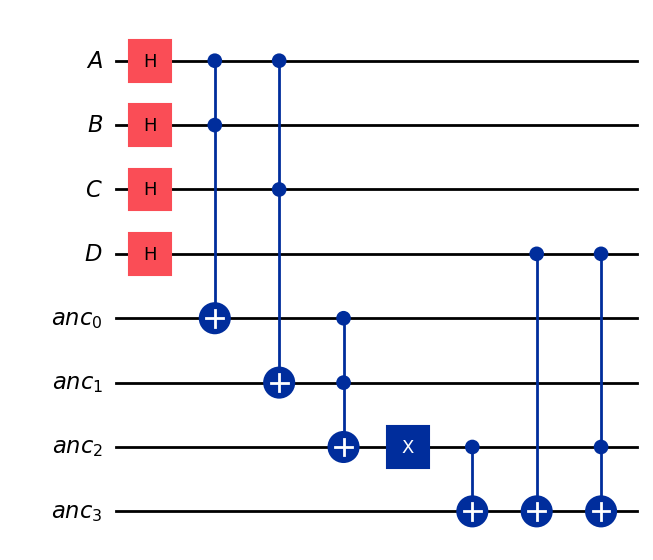

In [13]:
print("Our variable qubits and ancillas are:", qubits_map)
circuit.draw('mpl')

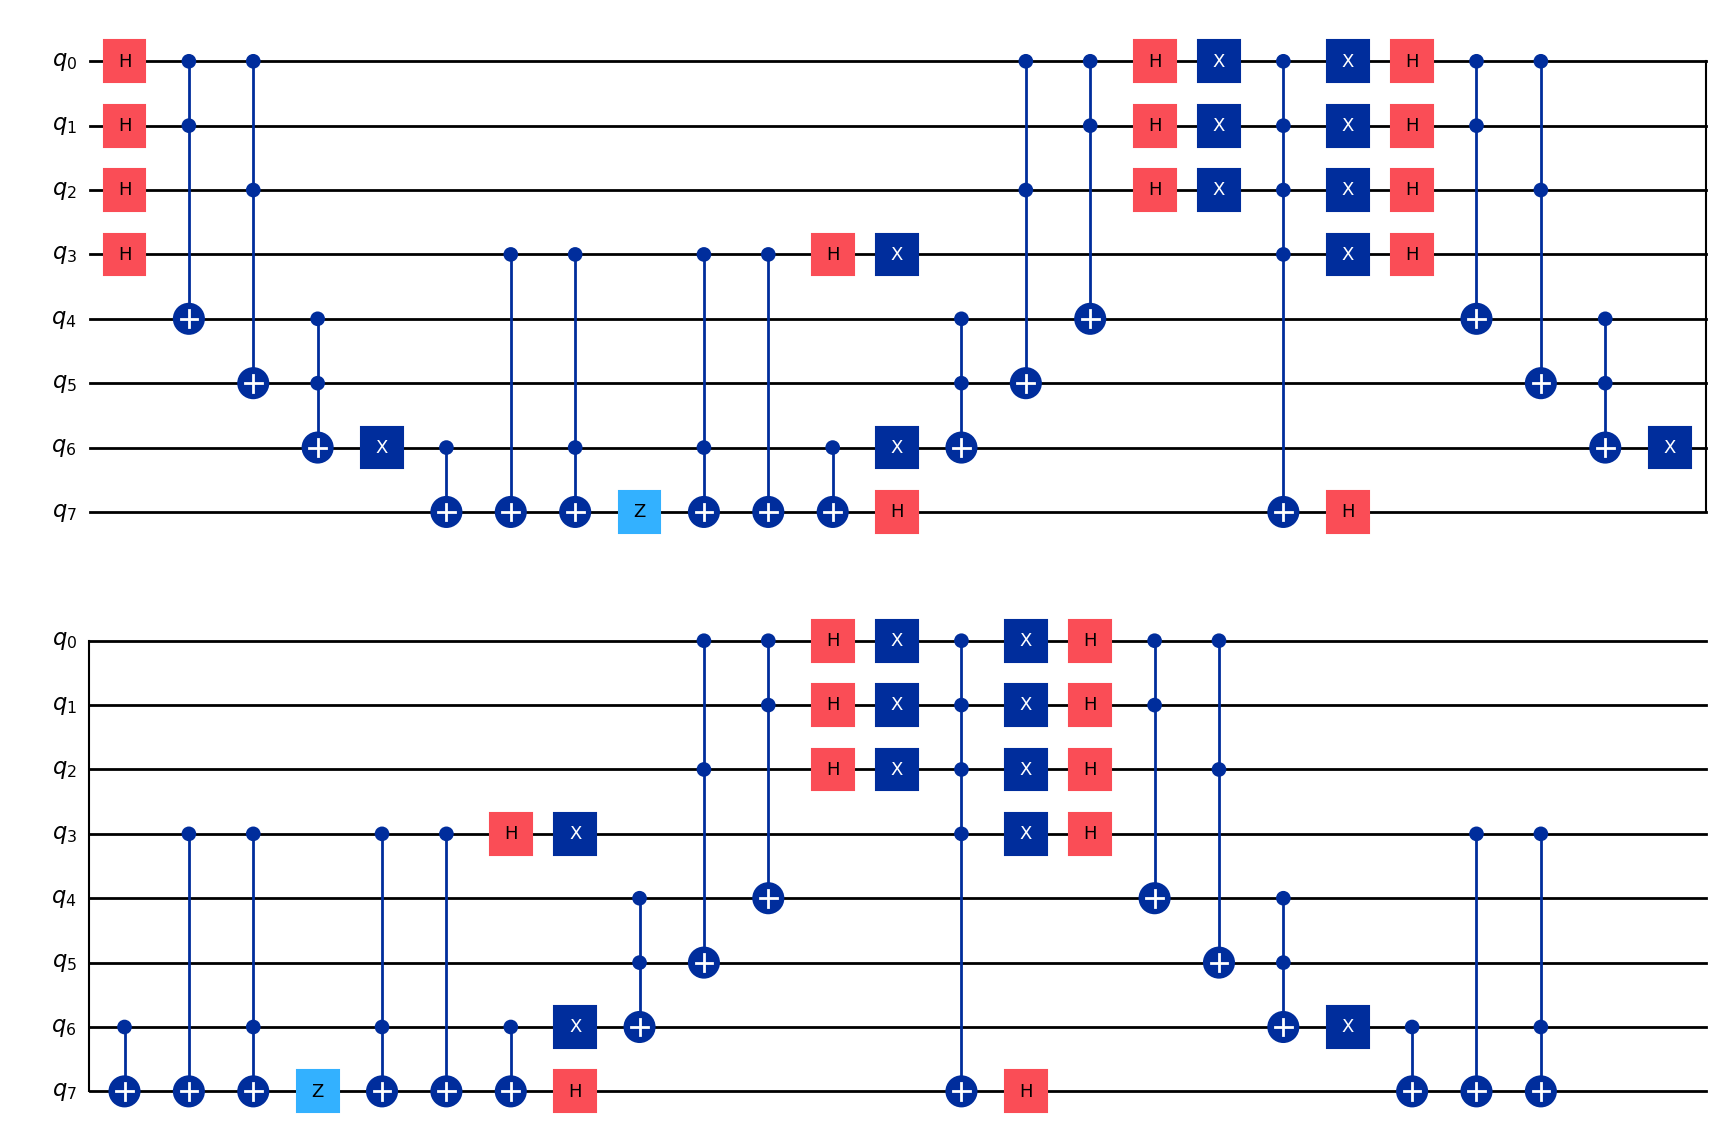

In [14]:
amplified_circuit.draw('mpl')